In [1]:
import json
import matplotlib.pyplot as plt
from numpy import array, zeros
import scipy
from scipy.misc import imread
from glob import glob
import os
import cv2
import numpy as np
import torch
import torchvision as vision
from torchvision import transforms
import joint_transforms
from torch.utils import data

In [2]:
IMG_PATH = '/media/data2TB/jeremyshi/data/cilia/train/data/'
MASK_PATH = '/media/data2TB/jeremyshi/data/cilia/train/masks/'

def load_input(base, split):
    '''
    Helper function to get the foler path. Under base (could be train, val, or test). 
    Return the path for under the folders of training imgs and masks.
    '''
    input_imgs = []
    masks_imgs = []
    all_hash = sorted(os.listdir(base + split + '/data/'))

    for imgHash in all_hash:
        inputs = glob(base + split + '/data/' + imgHash + '/*.png')
        input_imgs.append(array([imread(f, mode='I') for f in inputs]).sum(axis=0))
#         input_imgs.append(array([imread(f) for f in inputs]))
        if split != 'test':
            masks = glob(base + split + '/masks/' + imgHash + '.png')
            masks_imgs.append(array([imread(f, mode='I') for f in masks]))
#         masks_imgs.append(array([imread(f) for f in masks]))
        
    # check whether if they are good
    if len(input_imgs) == 0 or len(masks_imgs) == 0:
        raise RuntimeError('Found 0 images, please check the data set')
    if len(input_imgs) != len(masks_imgs):
        raise RuntimeError('Must be the same amount of the input and mask images!')
        
    # reshape the input
    for i in range(len(input_imgs)):
        input_imgs[i] = input_imgs[i].reshape(input_imgs[i].shape + (1,))
        input_imgs[i] = input_imgs[i].astype(np.int32)
    
    # reshape the mask
    for i in range(len(masks_imgs)):
        masks_imgs[i] = masks_imgs[i].reshape(masks_imgs[i][0].shape + (1,))
        masks_imgs[i] = masks_imgs[i].astype(np.int32)
    return input_imgs, masks_imgs

ROOT = '/media/data2TB/jeremyshi/data/cilia/'
# loaded = load_input(ROOT, 'train')

In [ ]:
# rc = vision.transforms.RandomCrop([256, 256])
# toPIL = vision.transforms.ToPILImage()
# toTensor = vision.transforms.ToTensor()
img_transform = transforms.Compose([
    transforms.ToPILImage(),
#     transforms.RandomCrop((256, 256)),
#     transforms.Resize((512,512)),
#       transforms.RandomHorizontalFlip(),
#       transforms.RandomVerticalFlip(),
#     transforms.Pad(16),
    transforms.ToTensor() 
])
# input = tiny_r_test[3].reshape(tiny_r_test[3].shape + (1,))
# input2 = tiny_r_test[4].reshape(tiny_r_test[4].shape + (1,))
input = loaded[1][0]
print (input.shape)
# out = toTensor(rc(toPIL(input)))
out = img_transform(input)
print(out.size())

In [ ]:
loaded[0][1].shape, loaded[1][1].size

In [ ]:
plt.imshow(loaded[0][1][:, :, 0], cmap='gray')

In [ ]:
for i in range(len(loaded[0])):
    loaded[0][i] = loaded[0][i].reshape(loaded[0][i].shape + (1,))

In [3]:
class CiliaData(data.Dataset):
    '''
    From https://github.com/bfortuner/pytorch_tiramisu/blob/master/datasets/camvid.py and 
    https://github.com/ZijunDeng/pytorch-semantic-segmentation/blob/master/datasets/cityscapes.py
    PyTorch class of dataset for loading input and target data. 
    __init__ starts a class.
    __getitem__ builds iterator of pairs of input and target images.
    __len__ returns the length of the dataset
    '''
    def __init__(self, root, split='train', joint_transform=None,
                 input_transform=None, target_transform=None):
        self.root = root
        assert split in ('train', 'validate', 'test')
        self.split = split
        self.input_transform = input_transform
        self.target_transform = target_transform
        self.joint_transform = joint_transform
        self.imgs, self.masks = load_input(self.root, split)
    
    def __getitem__(self, index):
        
        img, target = self.imgs[index], self.masks[index]
        
        # transform the img and target into PIL images (for cropping etc.)
        toPIL = transforms.ToPILImage()
        img, target = toPIL(img), toPIL(target)
        
        # we need joint transform because we need to crop the same area
        if self.joint_transform is not None:
            img, target = self.joint_transform(img, target)
        if self.input_transform is not None:
            img = self.input_transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target
    
    def __len__(self):
        return len(self.imgs)


In [4]:
import joint_transforms

ROOT = '/media/data2TB/jeremyshi/data/cilia/'
train_joint_transformer = joint_transforms.Compose([
    joint_transforms.RandomSizedCrop(256), 
    joint_transforms.RandomHorizontallyFlip()
    ])

new_transform = transforms.Compose([
#     transforms.ToPILImage()
#     transforms.RandomCrop((256, 256)),
#     transforms.Resize((512,512)),
#       transforms.RandomHorizontalFlip(),
#       transforms.RandomVerticalFlip(),
#     transforms.Pad(16),
    transforms.ToTensor()  
])
cilia = CiliaData(ROOT, 
                  joint_transform = train_joint_transformer, 
                  input_transform=new_transform, 
                  target_transform=new_transform
                 )

/home/local/AIUGA/jeremyshi/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
/home/local/AIUGA/jeremyshi/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


In [5]:
print (len(cilia))


159


In [6]:
input_a, target_a = next(iter(cilia))

In [7]:
train_loader = data.DataLoader(cilia, batch_size=10, shuffle=True)


In [8]:
import torchvision

In [9]:
input_b, target_b = next(iter(train_loader))

In [10]:
input_b.size(), target_b.size()

(torch.Size([10, 1, 256, 256]), torch.Size([10, 1, 256, 256]))

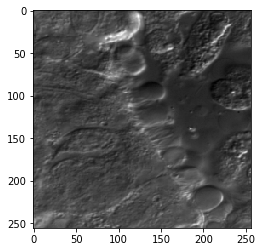

In [18]:
plt.imshow(input_b[7, 0, :, :], cmap='gray')

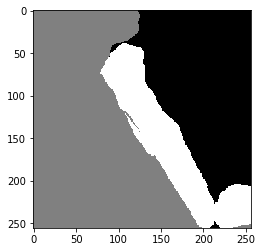

In [20]:
plt.imshow(target_b[7, 0, :, :], cmap='gray')

In [ ]:
input_a, target_a = next(iter(cilia))
input_a.shape

In [ ]:
target_a.shape

In [ ]:
plt.imshow(input_a[0, :, :, 0], cmap='gray')

In [ ]:
plt.imshow(target_a[:, :, 0])